## Sky Background Calculation (UVES/Gemini), flux within Iridian Filters

**Author:** Deborah Lokhorst (National Research Council Canada, Herzberg Astronomy & Astrophysics Research Centre)<br>
**Contact:** Deborah.Lokhorst@nrc-cnrc.gc.ca <br>
**Date:** 2024-02-16

In [1]:
%matplotlib inline

import os
import numpy as np
import matplotlib.pyplot as plt
from astropy import constants as const
from astropy import units as u
from astropy.io import fits
from pathlib import Path

### determining the sky background

#### Gemini Sky Background data  
(http://www.gemini.edu/sciops/ObsProcess/obsConstraints/atm-models/skybg_50_10.dat)

sky background 0.3-1.0um

DARK optical sky - 50%ile conditions (day 7)

AM=1.0

derived from (reverse engineered ESO model) sky spectrum plus constant slope to match assumed photometric background (from von Hippel model.

#### UVES Sky Background data  
(http://www.eso.org/observing/dfo/quality/UVES/pipeline/sky_spectrum.html)

These spectra were selected for a bunch of criteria, including:
"minimal moon contamination fractional lunar illumination < 0.05 and moon distance > 90 deg)"

That means that the scaled Gemini spectra is better (unless we also scale the UVES spectra)

Note that there are a bunch of column leaks in the UVES spectra -- make sure take that into account if end up using the UVES spectra for line identification!
>The REDU (red upper) CCD suffered from a leaking column causing broad quasi-emission in the echelle order. These features have been easily recognized due to their known position and atypical width. They are marked by squared crosses in the plots.

In particular, leaky columns at:<br>
6341 Angstroms<br>
6407 Angstroms<br>
6575 Angstroms<br>
6545 Angstroms<br>
66l5 Angstroms<br>
6689 Angstroms<br>


#### Compare
Want to compare the UVES and Gemini sky spectra.  To do this need to convert to the same units:  photon / s / cm^2 / arcsec^2 / nm.

Gemini is in: photon / s / **m^2** / arcsec^2 / nm 

* (m / 100cm) ^2

UVES is in: 1e-16 **erg** / s / cm^2 / arcsec^2 / **Angstrom**

* 1 photon / ( h c / lambda ) erg
* 10 Angstrom / nm

In [2]:
def getBackgroundGemini(start,end,geminiloc='/Users/lokhorstd/git/HalphaScripts/',plot=False,verbose=False):
    # Returns the total background flux in the wavlength interval supplied i.e. returns (flux)*(wavlength interval) 
    wavelength = []
    flux = []
    
    if not os.path.exists(geminiloc+'Gemini_skybackground.dat'):
        print(f"The file {geminiloc+'Gemini_skybackground.dat'} does not exist. Need to specify location of UVES sky flux data.")
        return None
    
    with open(geminiloc+'Gemini_skybackground.dat','r') as f:  #wavelength in nm, flux in phot/s/nm/arcsec^2/m^2
        for line in f:
            if line[0]!='#' and len(line)>5:
                tmp = line.split()
                wavelength.append(tmp[0])
                flux.append(tmp[1])
                
    wavelength = np.array(wavelength,'d')
    flux = np.array(flux,'d')
    
    start_ind = (np.abs(wavelength-start)).argmin()
    end_ind   = (np.abs(wavelength-end)).argmin()
        
    # if spacings are not even, need to add element by element
    total=0
    for index in np.arange(start_ind,end_ind):
      #  print index,index+1
      #  print total
        total = total+(flux[index]*(wavelength[index+1]-wavelength[index]))
    actualwavelenrangebefore = wavelength[end_ind+1]-wavelength[start_ind]
    if verbose:
        print (actualwavelenrangebefore)

    # slightly better
    total2=0
    for index in np.arange(start_ind,end_ind):
      #  print index,index+1
      #  print total
        total2 = total2 + (flux[index]*(wavelength[index+1]-wavelength[index])/2.) +\
                            (flux[index]*(wavelength[index]-wavelength[index-1])/2.)
            
    # same as total2
    fluxarray = flux[start_ind:end_ind]
    wavelenarray_left = wavelength[start_ind-1:end_ind-1]
    wavelenarray_cent = wavelength[start_ind:end_ind]
    wavelenarray_righ = wavelength[start_ind+1:end_ind+1]
    total3 = np.sum(fluxarray*(wavelenarray_righ-wavelenarray_left))/2.
           
    actualwavelenrange = np.mean([wavelenarray_cent[-1],wavelenarray_righ[-1]]) - \
                        np.mean([wavelenarray_left[0],wavelenarray_cent[0]])
    if verbose:
        print (actualwavelenrange)
        print (end-start)
        
    # scaling to match desired wavelength range, since resolution might not match up correctly
    total4 = total3 * (end-start)/actualwavelenrange
    
    if verbose:
        print ('COMPARE: %s and %s and %s and %s' % (total, total2, total3,total4)    )

    if plot==True:
        plt.plot(wavelength[start_ind-100:end_ind+100],flux[start_ind-100:end_ind+100])
        top = max(flux[start_ind-100:end_ind+100])
        plt.plot([start,start,end,end,start],[0,top,top,0,0])
        plt.show()
        
    return total4,wavelength[start_ind:end_ind],flux[start_ind:end_ind]

In [3]:
def getBackgroundUVES(start,end,uvesloc = '/Users/lokhorstd/Dropbox/Data/UVES_Sky_Background/UVES_sky_all/',plot=False,verbose=False):
    """
    Returns the UVES sky spectrum in the desired interval in units of
    wavelength: nm 
    flux: photon / s / nm / m**2 / arcsec**2
    """
    
    #start = start*10
    #end = end*10
    
    def getUVESBackground(filename):
        hdulist = fits.open(filename)
        flux = hdulist[0].data
    
        CRPIX1 = hdulist[0].header['CRPIX1']
        CRVAL1 = hdulist[0].header['CRVAL1']
        CDELT1 = hdulist[0].header['CDELT1']
        #print(CRPIX1,CRVAL1,CDELT1)
        hdulist.close()
        
        begin = CRVAL1 - CRPIX1*CDELT1   
        end = begin + len(flux)*CDELT1
        wavelength = np.arange(begin,end,CDELT1)
        #print(len(wavelength),len(flux))
        
        if len(wavelength)==(len(flux)+1):
            if verbose:
                print('wavelength array is one element longer than the flux array (UVES1).\
                Shortening the wavelength array.')
            wavelength = wavelength[0:-1]
        
        return wavelength,flux

    # Returns the total background flux in the wavlength interval supplied i.e. returns (flux)*(wavlength interval) 
    wavelength = []
    flux = []
    
    filename9 = "fluxed_sky_346.fits"  # 3140 - 3760
    filename0 = "fluxed_sky_437.fits"  # 3740 - 4940
    filename1 = "fluxed_sky_580L.fits" # 4810 - 5770
    filename2 = "fluxed_sky_580U.fits" # 5830 - 6790
    filename3 = "fluxed_sky_860L.fits" # 6700 - 8560
    
    leakycolumns = [6340.5, 6407, 6475.5,6545, 6616, 6689,6763] # locations where should mask data (not complete)
    # about 2 angstrom thick
    
    if not os.path.exists(uvesloc+filename9):
        print(f"The file {uvesloc+filename9} does not exist. Need to specify location of UVES sky flux data.")
        return None
    
    wavelength_UVES9,flux_UVES9=getUVESBackground(uvesloc+filename9) # 3140 - 3760
    wavelength_UVES0,flux_UVES0=getUVESBackground(uvesloc+filename0) # 3740 - 4940
    wavelength_UVES1,flux_UVES1=getUVESBackground(uvesloc+filename1) # 4810 - 5770
    wavelength_UVES2,flux_UVES2=getUVESBackground(uvesloc+filename2) # 5830 - 6790
    wavelength_UVES3,flux_UVES3=getUVESBackground(uvesloc+filename3) # 6700 - 8560

#     if len(wavelength_UVES1)==(len(flux_UVES1)+1):
#         if verbose:
#             print('wavelength array is one element longer than the flux array (UVES1).  Shortening the wavelength array.')
#         wavelength_UVES1 = wavelength_UVES1[0:-1]

#     if len(wavelength_UVES2)==(len(flux_UVES2)+1):
#         if verbose:
#             print('wavelength array is one element longer than the flux array (UVES2).  Shortening the wavelength array.')
#         wavelength_UVES2 = wavelength_UVES2[0:-1]
        
#     if len(wavelength_UVES3)==(len(flux_UVES3)+1):
#         if verbose:
#             print('wavelength array is one element longer than the flux array (UVES3).  Shortening the wavelength array.')
#         wavelength_UVES3 = wavelength_UVES3[0:-1]
        
    wavelength = np.concatenate((wavelength_UVES9[wavelength_UVES9<3740.],
                                 wavelength_UVES0[wavelength_UVES0>3740.],
                                 wavelength_UVES1[wavelength_UVES1>4940.],
                                 wavelength_UVES2[wavelength_UVES2<6700.],
                                 wavelength_UVES3[wavelength_UVES3>6700.]))
    flux = np.concatenate((flux_UVES9[wavelength_UVES9<3740.],
                           flux_UVES0[wavelength_UVES0>3740.],
                           flux_UVES1[wavelength_UVES1>4940.],
                           flux_UVES2[wavelength_UVES2<6700.],
                           flux_UVES3[wavelength_UVES3>6700.]))
        
    wavelength = np.array(wavelength,'d')
    flux = np.array(flux,'d')
    
    # convert the units to nm and ph / s / nm / m**2 / arcsec**2
    wavelength = wavelength / 10.  
        # Angs --> nm
    flux = flux *10**-16 * ((wavelength*10**-9)/(const.h.to('erg s').value * const.c.to('m/s').value)) * 10. * (100/1)**2 
        # (erg --> photon) and (/ Ang --> / nm) and (/ cm**2 --> / m**2)
        
    start_ind = (np.abs(wavelength-start)).argmin()
    end_ind   = (np.abs(wavelength-end)).argmin()
        
    # if spacings are not even, need to add element by element
    total=0
    for index in np.arange(start_ind,end_ind):
        total = total+(flux[index]*(wavelength[index+1]-wavelength[index]))
        
    # slight better
    fluxarray = flux[start_ind:end_ind]
    wavelenarray_left = wavelength[start_ind-1:end_ind-1]
    wavelenarray_cent = wavelength[start_ind:end_ind]
    wavelenarray_righ = wavelength[start_ind+1:end_ind+1]
    total3 = np.sum(fluxarray*(wavelenarray_righ-wavelenarray_left))/2.
           
    actualwavelenrange = np.mean([wavelenarray_cent[-1],wavelenarray_righ[-1]]) - \
                        np.mean([wavelenarray_left[0],wavelenarray_cent[0]])
    if verbose:
        print (actualwavelenrange)
        print (end-start)
        
    # scaling to match desired wavelength range, since resolution might not match up correctly
    total4 = total3 * (end-start)/actualwavelenrange
    
    if verbose:
        print ('COMPARE: %s and %s and %s'%(total,total3,total4))
        
    if plot==True:
        plt.plot(wavelength[start_ind-100:end_ind+100],flux[start_ind-100:end_ind+100])
        top = max(flux[start_ind-100:end_ind+100])
        plt.plot([start,start,end,end,start],[0,top,top,0,0])
        plt.show()
        
    return total4,wavelength[start_ind:end_ind],flux[start_ind:end_ind]

In [4]:
def loadUVESlinelists(datadir = '/Users/lokhorstd/Dropbox/Data/UVES_Sky_Background/UVES_ident/'):
    if not os.path.exists(datadir+'gident_580U.dat'):
        print(f"The file {datadir+'gident_580U.dat'} does not exist. Need to specify location of UVES sky flux data.")
        return None


    # UVES identified line lists
    line_wavelength = []
#    with open(datadir+'gident_437.dat','r') as f:
#        for line in f:
#            if line[0]!='#' and len(line)>5:
#                tmp = line.split()
#                line_wavelength.append(tmp[1])
#    with open(datadir+'gident_580L.dat','r') as f:
#        for line in f:
#            if line[0]!='#' and len(line)>5:
#                tmp = line.split()
#                line_wavelength.append(tmp[1])
    with open(datadir+'gident_580U.dat','r') as f:
        for line in f:
            if line[0]!='#' and len(line)>5:
                tmp = line.split()
                line_wavelength.append(tmp[1])
    with open(datadir+'gident_580U.dat','r') as f:
        for line in f:
            if line[0]!='#' and len(line)>5:
                tmp = line.split()
                line_wavelength.append(tmp[1])
    line_wavelength = np.array(line_wavelength,'d')
    
    return line_wavelength


In [5]:
def datareduce(data,factor,method = 'average'):
    if len(data)%factor != 0:
        print('Output data must have a integer number of cells: cannot reduce image pixels by a factor %i'%factor)
        return None
    data = np.split(data,len(data)/factor)
    data = np.sum(data,axis=-1)
    if method == 'average':
        data = data/float(factor)
    return data

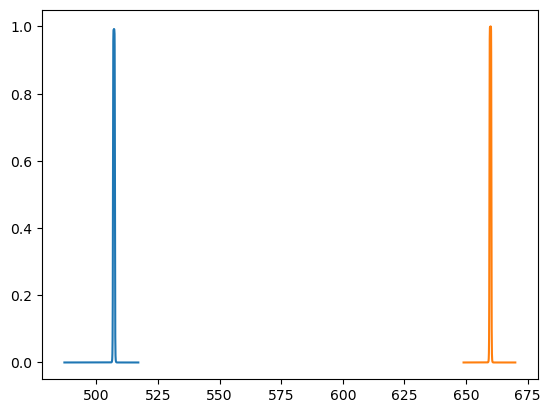

In [6]:
filterdict = {}

def loadFilter(thisfilter,wavefront='Collimated'):
    """Load the Iridian Transmission curves from the data files for different bandpass filters (BPF).
    
       thisfilter:  specify which Iridian filter to load
                       Options: '6599_3nm_0deg','6599_3nm_10deg','6599_08nm_0deg','6599_08nm_10deg',
                                 '6599_08nm_10deg_Gaus','6599_04nm_0deg','6599_04nm_10deg','Iridian_0.8BPF_0degsAOI_5071CWL'
       
       wavefront:  specify which wavefront type for the transmission curve
                       Options:  Collimated, ConeAngle22deg, ConeAngle3deg
    """
    # filter options
    filters = ['6599_3nm_0deg','6599_3nm_10deg','6599_08nm_0deg','6599_08nm_10deg',\
               '6599_08nm_10deg_Gaus','6599_04nm_0deg','6599_04nm_10deg',
               'Iridian_0.8BPF_0degsAOI_5071CWL']
    
    if thisfilter not in filters:
        print ("WARNING: Filter specified not in list of options.  Using default filter.")
        thisfilter = filters[0]
        
    # check if already loaded into dictionary first
    if thisfilter in filterdict:
        data = filterdict[thisfilter]
        return data['wavelen1'],data[wavefront]
    else:
        # load filter data from Iridian files
        data = []
        if (thisfilter =='Iridian_0.8BPF_0degsAOI_5071CWL'):
            data = np.genfromtxt('data/%s.dat'%thisfilter,  dtype='f', comments='#', delimiter=',',\
                                 names=('wavelen1', 'Collimated'))
        else:
            data = np.genfromtxt('data/%s.dat'%thisfilter,  dtype='f', \
                                 names=('wavelen1', 'Collimated', 'wavelen2', 'ConeAngle22deg', 'wavelen3','ConeAngle3deg'))
        # save into dictionary
        filterdict[thisfilter] = data

        return data['wavelen1'],data[wavefront]

def getHalphaSpec(AOI = 0):
    fname = 'data/halpha.dat'
    if AOI!=0:
        fname = 'data/halpha_shifted.dat'
    data = np.genfromtxt(fname,  dtype='f', names=('wavelength', 'flux'))
    return data['wavelength'],data['flux']
    
def getFlux(thisfilter,datadir =None, axis =None, sspectra = 'Gemini',shiftspectra=False,wavefront='Collimated',AOI=0):
    """Integrate over the filter and sky background spectrum.
    
        thisfilter:  specify which Iridian filter to load
        
        datadir: specify where the spectral data is located

        sspectra: specify which source spectra to use to integrate over and get total flux
                    Options: (sky background) Gemini, UVES (science) halpha
        
    """
    # load data
    if (thisfilter =='Iridian_0.8BPF_0degsAOI_5071CWL'):
        wavelenrange = (490.,520.)
    else:
        wavelenrange = (640.,680.)
    if sspectra == 'Gemini':
        _, dwavelength, dflux = getBackgroundGemini(wavelenrange[0],wavelenrange[1],geminiloc=datadir)
    elif sspectra =='UVES':
        _, dwavelength, dflux = getBackgroundUVES(wavelenrange[0],wavelenrange[1],uvesloc=datadir)
    elif sspectra == 'halpha':
        dwavelength, dflux = getHalphaSpec(AOI=0)
    elif type(sspectra) is tuple:
        print ("WARNING: Taking input as a tuple containing (wavelength,flux) for source spectra.")
        dwavelength, dflux = sspectra[0],sspectra[1]
    else:
        print ("WARNING: Input source spectra not recognized. Please choose Gemini, UVES, or halpha. Returning None.")
        return None
    
    if type(shiftspectra) is float:
        print ('Shifting spectra by %s...'%shiftspectra)
        dwavelength = dwavelength-shiftspectra
    elif shiftspectra:
        print ('Shifting spectra by 2.42...')
        dwavelength = dwavelength-2.42

    # load transmission curve
    twavelength, tflux = loadFilter(thisfilter,wavefront=wavefront) #transmission curve of the filter
    
    # reinterpolate transmission onto the same wavelength def as the data
    itflux = np.interp(dwavelength, twavelength, tflux, left=0., right=0.)  
            ## left and right are the values for tflux for dwavelength outside range of twavelength
        
    if axis is not None:
        axis.plot(dwavelength, dflux)
        axis.plot(twavelength, tflux)
        
    # if the filter is null on that wavelength range flux is then 0
    ind = itflux > 0.  # makes a masked array where True if >0 and False if <=0
    
    if True in ind:
        # limit integrals to where necessary
        # ind = itflux > 0.
        total = np.trapz( itflux[ind] * dflux[ind], dwavelength[ind], axis=-1)
        if np.isinf(total).any():
            print("WARNING: inf value from integration.")
        return total
    else:
        return 0.

twavelength, tflux = loadFilter('Iridian_0.8BPF_0degsAOI_5071CWL',wavefront='Collimated')
plt.plot(twavelength, tflux)

twavelength, tflux = loadFilter('6599_08nm_0deg',wavefront='Collimated')
plt.plot(twavelength, tflux)

In [7]:
plt.style.use('seaborn-dark-palette')
plt.style.use('ggplot')
font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 16}
import matplotlib
matplotlib.rc('font', **font)

/var/folders/cx/tgcvyx4j0dv34dk3cw2x965w0000gp/T/ipykernel_98871/2961411380.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-dark-palette')


In [10]:
# define uvesloc (where the UVES sky flux data lives), uveslineloc (where UVES sky line data exists), and geminiloc (where Gemini sky data exists)

uvesloc = 'data/UVES_Sky_Background/UVES_sky_all/'
uveslineloc = 'data/UVES_Sky_Background/UVES_ident/'
geminiloc = 'data/'

if not Path(uvesloc).exists():
    print('ERROR: Redefine path to the UVES sky data, the directory you defined doesn\'t exist.')
if not Path(uveslineloc).exists():
    print('ERROR: Redefine path to the UVES line data, the directory you defined doesn\'t exist.')
if not Path(geminiloc).exists():
    print('ERROR: Redefine path to the Gemini sky data, the directory you defined doesn\'t exist.')



data/UVES_Sky_Background/UVES_sky_all/
data/UVES_Sky_Background/UVES_ident/
data/


In [11]:
line_wavelengths = loadUVESlinelists(uveslineloc)

In [12]:
SMALL_SIZE = 16
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

reds = plt.get_cmap("Reds")
blues = plt.get_cmap("Blues")


440.19999999999993
439.93499999999995
440.0
COMPARE: 291.74789699999945 and 291.7339194999994 and 291.73391949999956 and 291.7770229238406
Gemini and UVES total flux of sky background within 360.0 nm and 800.0 nm: 	 291.78, 202.60

-113.0
113
119600


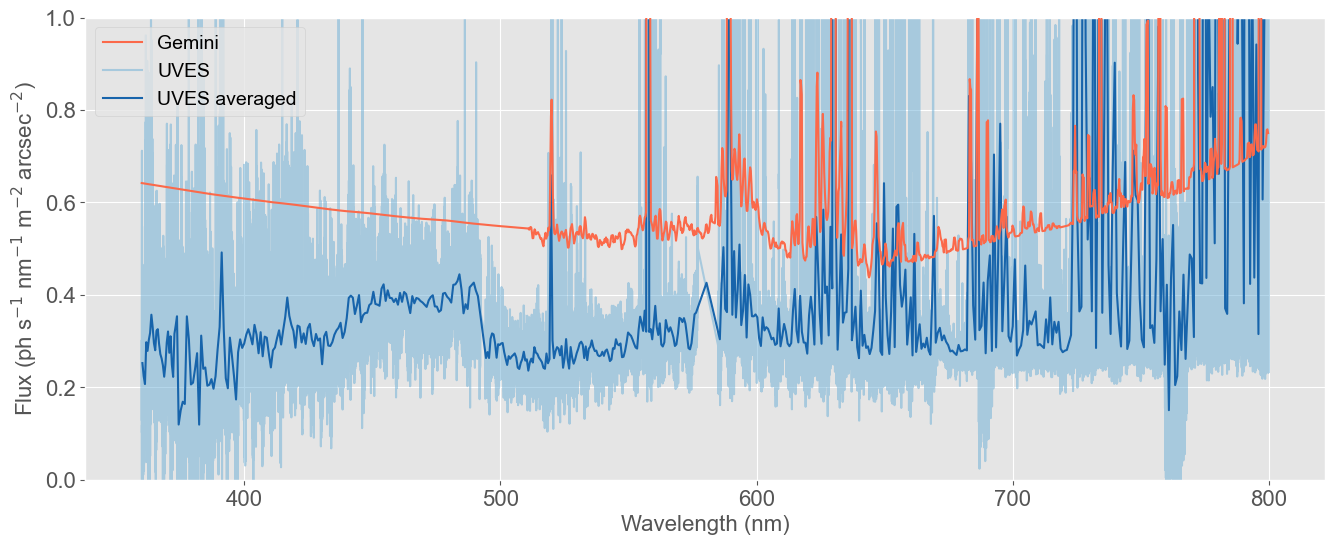

In [13]:
# Start off the plot with the basic curves
start_1 = 360.
end_1 = 800.  
total_G,wavelen_G_ha,flux_G_ha = getBackgroundGemini(start_1,end_1,geminiloc=geminiloc,plot=False,verbose=True);
total_U,wavelen_U_ha,flux_U_ha = getBackgroundUVES(start_1,end_1,uvesloc=uvesloc,plot=False);
print ('Gemini and UVES total flux of sky background within %s nm and %s nm: \t %0.2f, %0.2f\n'%\
        (start_1,end_1, total_G, total_U))

factor=200
lim = -1. * (len(flux_U_ha)%factor)
print (lim)
print (len(flux_U_ha)%factor)
print (len(flux_U_ha[:int(lim)]))
if lim!=0:
    fluxsum = datareduce(flux_U_ha[:int(lim)],factor,method='average')
    wavelensum = datareduce(wavelen_U_ha[:int(lim)],factor)
else:
    fluxsum = datareduce(flux_U_ha,factor,method='average')
    wavelensum = datareduce(wavelen_U_ha,factor)


f, axx = plt.subplots(1,1,figsize = (16,6))
axx.plot(wavelen_G_ha,flux_G_ha,label='Gemini',color=reds(0.5),zorder=10)
axx.plot(wavelen_U_ha,flux_U_ha,label='UVES',color=blues(0.5),alpha=0.5)
axx.plot(wavelensum,fluxsum,label='UVES averaged',color=blues(0.8))

axx.set_ylim(0,1)
axx.set_ylabel(r'Flux (ph s$^{-1}$ nm$^{-1}$ m$^{-2}$ arcsec$^{-2}$)')
axx.set_xlabel('Wavelength (nm)')
axx.legend(loc=2,fontsize=14)

Gemini and UVES total flux of sky background within 650.0 nm and 670.0 nm: 	 9.77, 7.42

Gemini and UVES total flux of sky background within 495.0 nm and 510.0 nm: 	 8.21, 4.11



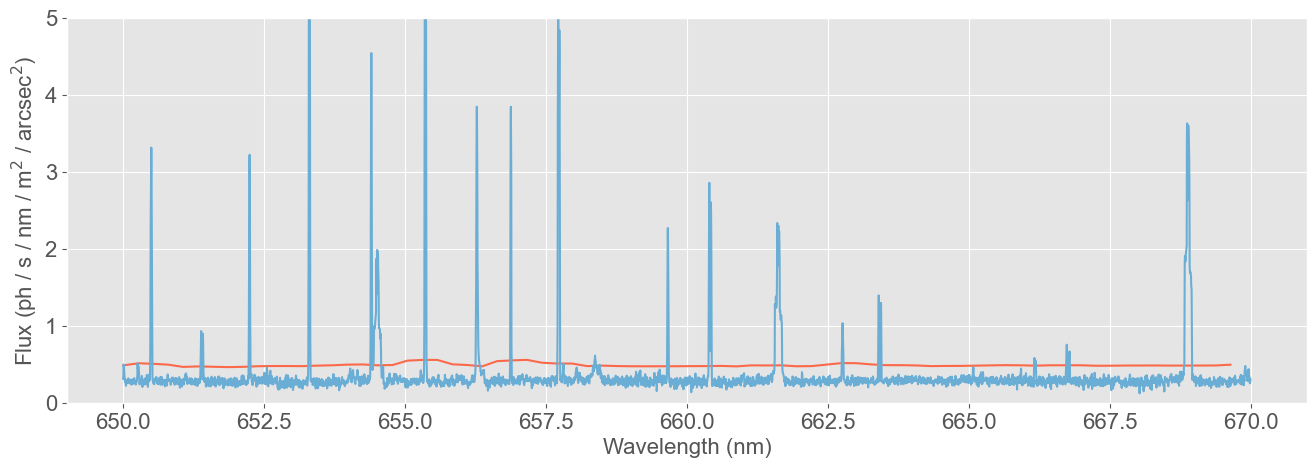

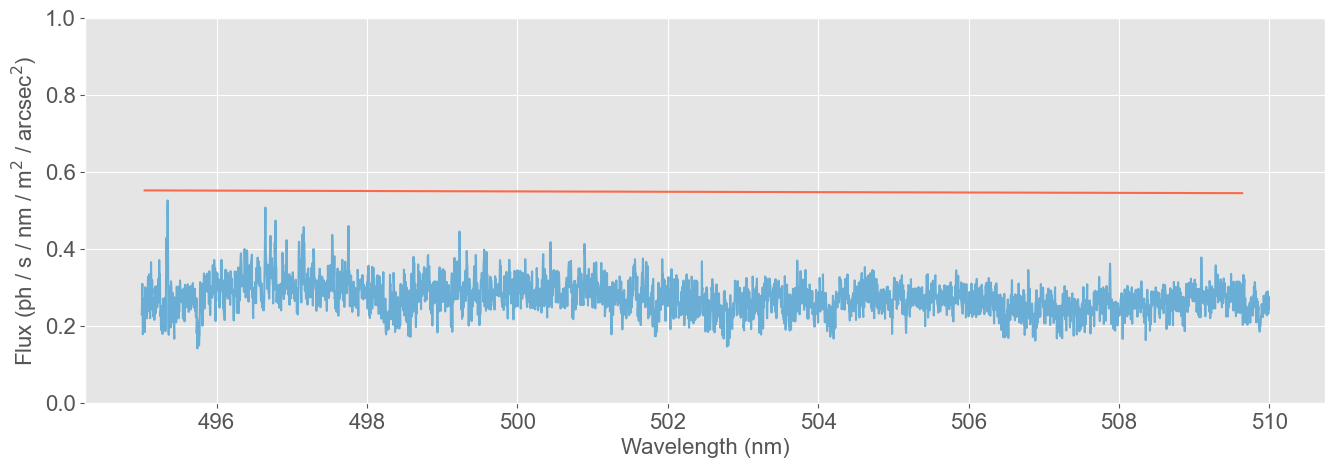

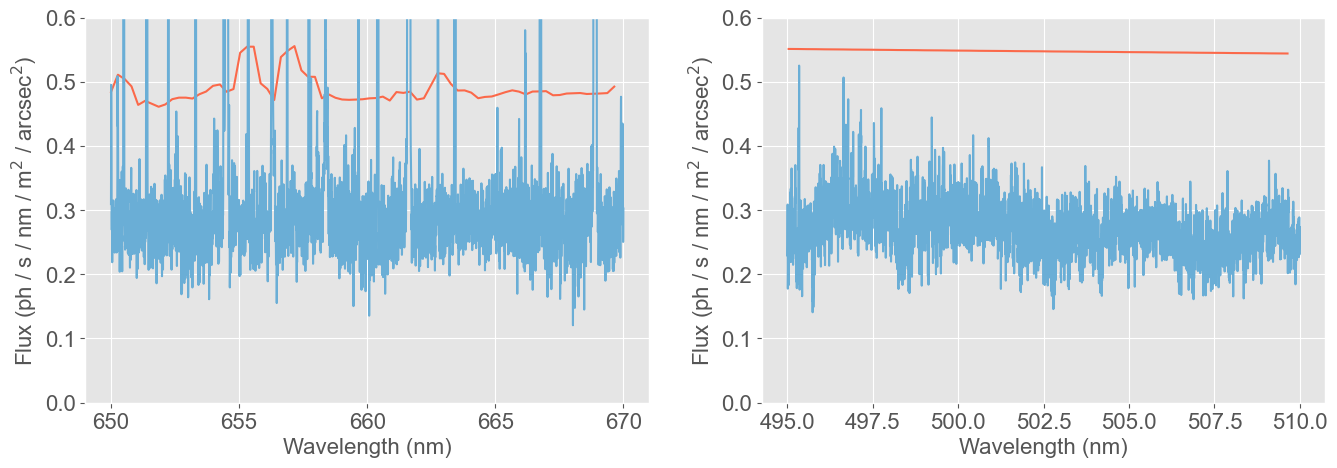

In [14]:
# Start off the plot with the basic curves
start_1 = 650.
end_1 = 670.
total_G,wavelen_G_ha,flux_G_ha = getBackgroundGemini(start_1,end_1,geminiloc=geminiloc,plot=False);
total_U,wavelen_U_ha,flux_U_ha = getBackgroundUVES(start_1,end_1,uvesloc=uvesloc,plot=False);
print ('Gemini and UVES total flux of sky background within %s nm and %s nm: \t %0.2f, %0.2f\n'%\
        (start_1,end_1, total_G, total_U))

f, axx = plt.subplots(1,1,figsize = (16,5))
axx.plot(wavelen_G_ha,flux_G_ha,label='Gemini',color=reds(0.5))
axx.plot(wavelen_U_ha,flux_U_ha,label='UVES',color=blues(0.5))
axx.set_ylim(0,5)

# Start off the plot with the basic curves
start_1 = 495.
end_1 = 510.
total_G,wavelen_G_oiii,flux_G_oiii = getBackgroundGemini(start_1,end_1,geminiloc=geminiloc,plot=False);
total_U,wavelen_U_oiii,flux_U_oiii = getBackgroundUVES(start_1,end_1,uvesloc=uvesloc,plot=False);
print ('Gemini and UVES total flux of sky background within %s nm and %s nm: \t %0.2f, %0.2f\n'%\
        (start_1,end_1, total_G, total_U))

f, ax = plt.subplots(1,1,figsize = (16,5))
ax.plot(wavelen_G_oiii,flux_G_oiii,label='Gemini',color=reds(0.5))
ax.plot(wavelen_U_oiii,flux_U_oiii,label='UVES',color=blues(0.5))
ax.set_ylim(0,1)

fig, (ax1,ax2) = plt.subplots(1,2,figsize = (16,5))
ax1.plot(wavelen_G_ha,flux_G_ha,label='Gemini',color=reds(0.5))
ax1.plot(wavelen_U_ha,flux_U_ha,label='UVES',color=blues(0.5))
ax2.plot(wavelen_G_oiii,flux_G_oiii,label='Gemini',color=reds(0.5))
ax2.plot(wavelen_U_oiii,flux_U_oiii,label='UVES',color=blues(0.5))
ax1.set_ylim(0,0.6)
ax2.set_ylim(0,0.6)

for axis in [axx,ax,ax1,ax2]:
    axis.set_ylabel(r'Flux (ph / s / nm / m$^2$ / arcsec$^2$)')
    axis.set_xlabel('Wavelength (nm)')
    

In [15]:
filters = ['6599_3nm_0deg','6599_3nm_10deg',
           '6599_08nm_0deg','6599_08nm_10deg','6599_08nm_10deg_Gaus', # H-alpha filter
           '6599_04nm_0deg','6599_04nm_10deg',
           'Iridian_0.8BPF_0degsAOI_5071CWL']  # [OIII] filter

wavefronts = ['Collimated', 'ConeAngle22deg', 'ConeAngle3deg']
wavefronts = ['Collimated']

filters_0deg = [filt for filt in filters if '_0deg' in filt]

for thisfilter in filters_0deg:
    for wavefront in wavefronts:
        print (thisfilter, wavefront)
        print (getFlux(thisfilter,sspectra = 'Gemini',datadir=geminiloc,wavefront=wavefront))
        print (getFlux(thisfilter,sspectra = 'UVES',datadir=uvesloc,wavefront=wavefront))
#         print (getFlux(thisfilter,sspectra = 'halpha',machine=machine,wavefront=wavefront))
        print ("")

6599_3nm_0deg Collimated
1.5044920900960372
1.0754011954878129

6599_08nm_0deg Collimated
0.3887303184993624
0.27643575910184537

6599_04nm_0deg Collimated
0.22423687448343918
0.12158037418159096

Iridian_0.8BPF_0degsAOI_5071CWL Collimated
0.4440921270756751
0.19747308583566975



#### Results:

UVES Sky background in the 507.1 0.8nm filter ([OIII] filter): 0.197

UVES Sky background in the 669.9 0.8nm filter (H-alpha filter): 0.276

### Conclusions:

Though the UVES spectrum is much higher resolution (75x higher) and is higher signal-to-noise, which makes it more sensitive to sky lines, the two spectra are consistent with one another.

Further, they are consistent with the night sky conditions when they were taken (the UVES spectra was taken on only the darkest nights, whereas the Gemini spectra is scaled to match the 50%-ile conditions of the observing nights), so the Gemini spectra is expected to be brighter.

Have demonstrated the sky background calculation within variable filter widths in preparation for using it to calculate surface brightnesses.

Have demonstrated that the Gemini sky brightness spectra is a reasonable approximation of the sky brightness where the emission lines are averaged over large filter widths.

Further steps:
- take the Gemini spectra sky flux in the filterwidth and use them to produce signal-to-noise estimates
- use the UVES spectra to calculate the sky flux and scale it appropriately with moon brightness, etc, to do a better simulation of the effects of avoiding sky lines.